C:\Users\user\AppData\Local\Temp\ipykernel_66148\2388510062.py:166: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(float(error))
C:\Users\user\AppData\Local\Temp\ipykernel_66148\2388510062.py:169: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f'x = {row["x"]} : label {row["y"]} : predict = {self.layers[-1].a_vector} :COST = {float(error)}')
C:\Users\user\AppData\Local\Temp\ipykernel_66148\2388510062.py:239: RuntimeWarning: overflow encountered in exp
  self.a_vector = 1 / (1 + np.exp(-self.z_vector))


23.70958819719682
x = 17.4121679 : label -4.821160557 : predict = [2.06499776] :COST = 23.70958819719682
37.769034318405375
x = -7.758894255 : label -6.760179804 : predict = [1.93108412] :COST = 37.769034318405375
36.38921981452536
x = -4.137945726 : label -6.519888132 : predict = [2.01113992] :COST = 36.38921981452536
23.92132627164837
x = 22.36804841 : label -4.851840415 : predict = [2.06499792] :COST = 23.92132627164837
24.876584963899315
x = 24.69423591 : label -4.988594754 : predict = [2.06499794] :COST = 24.876584963899315
36.69763030401722
x = -5.002302533 : label -6.579407907 : predict = [1.98769549] :COST = 36.69763030401722
27.627508836420787
x = 9.765308829 : label -5.368375994 : predict = [2.0649959] :COST = 27.627508836420787
35.66298544603912
x = 41.19000916 : label -6.380472471 : predict = [2.06499797] :COST = 35.66298544603912
33.53676366728508
x = 37.86637821 : label -6.124844972 : predict = [2.06499797] :COST = 33.53676366728508
23.64916626651428
x = 17.69054342 : lab

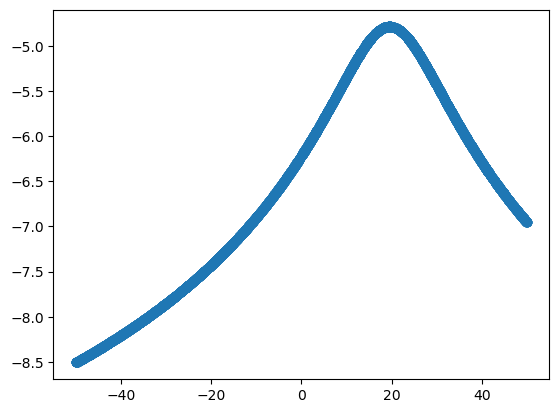

In [57]:

import pandas as pd
import numpy as np
import math
df = pd.read_csv("hw2_data.csv")

import matplotlib.pyplot as plt

plt.scatter(df['x'], df['y'])


class MLP_network:
    def __init__(self, node_config: list, activation_config: list):
        # node_config에는 Layer에 몇 개의 노드를 가질 것인지 나타낸다. 
        # Ex) [1, 2, 3, 3, 3, 1]
        # 5층에 각 층별로 1개, 2개, 3개, ... 1개씩 존재한다.
        self.node_configuration = node_config
        self.activation_config = activation_config
        # 각 노드에 하나씩 존재하도록 한다. 
        # 별도로 Bias는 Backpropagation 연산에는 포함되지 않도록 하며
        # 별도의 업데이트 과정을 거치도록 한다. 
        # 처음 학습을 시작할 때 별도로 bias_list를 초기화하는 과정을 거치도록 한다. 
        self.bias_list = list()

        # 3차원 큐브의 형태로 구성하고 있는 weight 정보
        # 한 Layer가 다른 layer로 전사될 때 하나의 Matrix가 사용된다. 
        # Bias는 별도로 업데이트 된다. 
        # 처음 학습을 시작할 때 별도로 weight_list를 초기화하는 과정을 거치도록 한다. 
        self.weight_list = list()

        # layer를 담도록 하는 list 객체
        # MLP 선언과 동시에 layer 정보가 담겨야 한다. 
        self.layers = []

        self.stack_delta_list = []

        return

        # 현재로써는 모든 노드가 identity를 activation 함수로 가지도록 한다. 
    # 추가적으로 activation 함수 또한 수정할 수 있도록 바꿔야 한다. 
    # 입력층에 값을 할당하는 것은 set_value 함수에서 하도록 한다.
    # Weight를 일괄적으로 initialization하는데 초점을 둔다. 
    # 별도로 Weight 외에, Bias 또한 일괄적으로 Update한다. 
    # 해당 함수를 사용해서, Matrix를 새로 초기화한다.
    def _configure_network(self):
        for index in range(len(self.node_configuration)):
            node_info = self.node_configuration[index]
            activation_info = self.activation_config[index]
            self.layers.append(Layer(node_info,activation_info))
        self.layers[0].is_first = True
        self.layers[-1].is_final = True
        for i in range(len(self.node_configuration)-1):
            # MLP에 초기 무직위 weight 정보 구성
            self.weight_list.append(np.random.rand(self.node_configuration[i+1], self.node_configuration[i]))
            self.bias_list.append(np.random.rand(self.node_configuration[i+1]))
            self.stack_delta_list.append(np.zeros((self.node_configuration[i+1], self.node_configuration[i])))
    def _refresh_stack_delta_list(self):
        for i in range(len(self.node_configuration)-1):
            self.stack_delta_list[i] = np.zeros((self.node_configuration[i+1], self.node_configuration[i]))
    # MLP 순전파 연산만 담당하도록 한다.
    # 입력 값을 넣는 과정은 set_value 함수가 담당하도록 한다. 
    # 여기에서는 단순하게 a 값을 반환하도록 한다.
    # 가중치 업데이트를 위한 a 값 획득은 training 단계에서 해결하도록 한다. 
    # 전파 과정은 다음 식으로 표현될 수 있다.
    # z = Wa + b
    # 순서가 다르다는 것에 유의하자.
    def forward_propagation(self):
        for i in range(len(self.node_configuration)-1):

            # 1차원 벡터 형식
            tempInput : np.ndarray = self.layers[i].a_vector

            # 2차원 행렬 형식
            tempWeight : np.ndarray = self.weight_list[i]

            # 1차원 벡터 형식 : 최종적으로 z_vector에 입력된다. 
            tempOutput : np.ndarray = np.zeros((1,self.node_configuration[i]))

            # 합산 z 구하는 과정
            tempOutput : np.ndarray = tempWeight @ tempInput



            # 노드 간 행렬곱 -> z 값 저장
            # Throw 발생으로 추정됨
            self.layers[i+1].z_vector = tempOutput + self.bias_list[i]
            #  -+> Activation Function 적용 호출
            self.layers[i+1].activation_function()
        return

        # backpropagation 가중치 update를 바라보고 알고리즘을 구성하는 것이 좋을 것 같음
    def backpropagation(self, y):

        # L 번째 Layer -+> L-1 번째 weight, Layer 
        self.layers[-1].delta_vector = self.layers[-1].a_vector - y

        # TO DO : 역전파 알고리즘에 적절하게 Range 메서드 인자 값 수정할 것
        for i in range(len(self.node_configuration)-2, 0, -1):
            # i - 1 Weight matrix와 연산해야 함
            # 전치된 행렬 얻음
            temp_weight_holder = self.weight_list[i].transpose()

            # delta 정보 전파
            self.layers[i].delta_vector = temp_weight_holder @ self.layers[i+1].delta_vector # 별도로 pairwise 연산 추가해야함

            # wrong code for updating
            #self.layers[i].batch_delta_vector += self.layers[i].delta_vector

            # this is actually right code
            temp = np.outer(self.layers[i+1].delta_vector, self.layers[i].a_vector)
            self.stack_delta_list[i] = self.stack_delta_list[i] + temp
        return

    # batch iteration은 단순히 순전파, 역전파를 진행하고, 누적 delta 값을 하는데 초점을 맞춘다. 
    # batch 내의 데이터를 가지고 노는 역할
    def batch_iteration(self, data_set : pd.DataFrame, batch_size : int,learning_rate : float, bias_lambda : float):
        # 1회 Batch 실행할 때, 반드시 가중치 Matrix를 다시 초기화해야 한다.
        self._configure_network()

        for batch in np.array_split(data_set.sample(frac = 1), len(data_set) // batch_size):

            # iterate for every batch entity element 
            for index, row in batch.iterrows():
                self.set_value(row['x'])
                self.forward_propagation()

                #get error
                # 내 코드는 하나의 에러에 대해서만 Back-propagation을 수행하려고 함
                error = 0.5 * (self.layers[-1].a_vector - row['y'])**2
                print(float(error))

                self.backpropagation(row['y'])
                print(f'x = {row["x"]} : label {row["y"]} : predict = {self.layers[-1].a_vector} :COST = {float(error)}')
            # batch iteration end

            self.weight_update(batch_size, learning_rate, bias_lambda)
            #self.bias_update(batch_size, learning_rate)
            # soft reset for next batch
            for i in self.layers:
                i.delta_vector = None
                i.batch_delta_vector = 0
            self._refresh_stack_delta_list()
        return

        # batch_iteration 완료 후, 각 layer 별로 delta 값에 따라서 weight와 Bias를 Update한다
    def weight_update(self, batch_size : int,learning_rate : float, bias_lambda: float ):

        # 각 Layer를 역방향으로 탐색해오면서 누적 노드 Delta 값과 activation value를 곱한 Update Factor를 
        # learning Rate와 함께 곱하면서 weight와 Bias를 구한다.

        for i in range(len(self.weight_list)):
            D = (1/batch_size)*(self.stack_delta_list[i] + bias_lambda * self.weight_list[i])
            self.weight_list[i] = self.weight_list[i] - learning_rate * D

    # 해당 함수에서는 최종적으로 조정된 Parameter를 가지고 예측했을 때의 오차를 나타낸다.
    def validation(self, validation_data_set):
        total_error = 0
        total_samples = len(validation_data_set)
        for index, row in validation_data_set.iterrows():
            self.set_value(row['x'])
            self.forward_propagation()
            error = (self.layers[-1].a_vector - row['y']) ** 2
            total_error += error

        # cost function도 함수로 제공하면 좋을 듯
        mse = total_error / total_samples
        return mse

    # 단순히 입력층에 대해서만 값을 결정시킨다.
    # 출력층의 label은 별도로 Backpropagation과 validation, prediction에서 manual하게 다루게 한다.
    def set_value(self,x):
        self.layers[0].a_vector = np.array([x])

    # bias_list는 i + 1번째 layer가 i번째에 있음
    # 
    def bias_update(self,batch_size, learning_rate : float):
        for i in range(len(self.bias_list)):
            self.bias_list[i] = self.bias_list[i] - learning_rate * (1/batch_size) * self.layers[i+1].batch_delta_vector
    def just_prediction(self, input_data):
        self.set_value(input_data)
        self.forward_propagation()
        return self.layers[-1].a_vector[0]

 
class Layer:
    def __init__(self, num_nodes, diff: str, is_first:bool = False, is_final:bool=False):
        self.num_node = num_nodes
        self.z_vector : np.ndarray = None
        self.a_vector : np.ndarray = None
        self.delta_vector : np.ndarray = None
        self.batch_delta_vector = 0
        self._diff_info = diff
        self.is_final = False
        self.is_first = False

    def activation_function(self):
        if self._diff_info == 'sigmoid':
            self._sigmoid()
        elif self._diff_info == 'identity':
            self._identity()

    def _sigmoid(self):
        self.a_vector = 1 / (1 + np.exp(-self.z_vector))

    def _identity(self):
        self.a_vector = self.z_vector
    def clear_batch_delta_vector(self):
        self.batch_delta_vector = None

mlp = MLP_network([1,3,5,8,4,1], ['identity','identity','sigmoid', 'identity','sigmoid','identity'])

base_data_set = pd.read_csv('hw2_data.csv')

training_data_set = base_data_set.sample(frac=1).reset_index(drop=True)

spliter = int(len(df) * 0.8)

training_data_set = base_data_set[:spliter]
validation_data_set = base_data_set[spliter:]

mlp.batch_iteration(training_data_set, 100,0.1,0)
print(mlp.validation(validation_data_set))

In [58]:
df

,x,y
0,-19.887859,-7.421269
1,-20.193776,-7.435642
2,32.592798,-5.673912
3,-36.360456,-8.083372
4,31.458041,-5.571183
...,...,...
4995,4.308065,-5.859489
4996,45.670388,-6.690394
4997,-13.247582,-7.083517
4998,-47.353932,-8.431461


In [56]:
x_values = np.linspace(df['x'].min(), df['x'].max(), len(df))  # 입력 데이터 생성
predicted_values = list()
for i in range(len(x_values)):
    temp = mlp.just_prediction(x_values[i])
    predicted_values.append(temp)
    print(temp)
result = pd.DataFrame ( {'x':x_values, 'y': predicted_values})
result

-6.613542554654001
-6.613542554654001
-6.613542554654001
-6.613542554654001
-6.613542554654001
-6.613542554654001
-6.613542554654001
-6.613542554654001
-6.613542554654001
-6.613542554654001
-6.613542554654001
-6.613542554654001
-6.613542554654001
-6.613542554654001
-6.613542554654001
-6.613542554654001
-6.613542554654001
-6.613542554654001
-6.613542554654001
-6.613542554654001
-6.613542554654001
-6.613542554654001
-6.613542554654001
-6.613542554654001
-6.613542554654001
-6.613542554654001
-6.613542554654001
-6.613542554654001
-6.613542554654001
-6.613542554654001
-6.613542554654001
-6.613542554654001
-6.613542554654001
-6.613542554654001
-6.613542554654001
-6.613542554654001
-6.613542554654001
-6.613542554654001
-6.613542554654001
-6.613542554654001
-6.613542554654001
-6.613542554654001
-6.613542554654001
-6.613542554654001
-6.613542554654001
-6.613542554654001
-6.613542554654001
-6.613542554654001
-6.613542554654001
-6.613542554654001
-6.613542554654001
-6.613542554654001
-6.613542554

C:\Users\user\AppData\Local\Temp\ipykernel_66148\2160626500.py:239: RuntimeWarning: overflow encountered in exp
  self.a_vector = 1 / (1 + np.exp(-self.z_vector))


,x,y
0,-49.995166,-6.613543
1,-49.975166,-6.613543
2,-49.955166,-6.613543
3,-49.935166,-6.613543
4,-49.915166,-6.613543
...,...,...
4995,49.903929,-6.613543
4996,49.923929,-6.613543
4997,49.943929,-6.613543
4998,49.963929,-6.613543


ValueError: x and y must be the same size

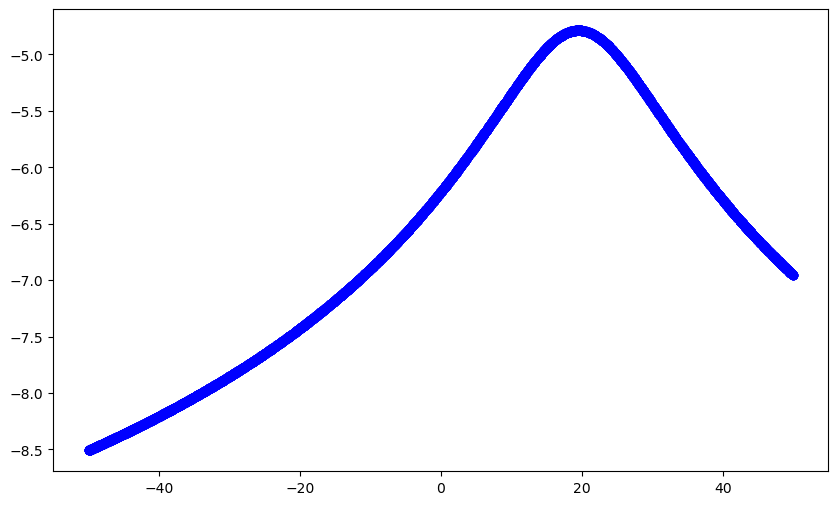

In [48]:
# 실제 라벨과 예측값을 동시에 플롯에 그리기
plt.figure(figsize=(10, 6))
plt.scatter(df['x'], df['y'], label='Actual Labels', color='blue')
plt.scatter(x_values, predicted_values, label='Predictions', color='red')
plt.xlabel('x values')
plt.ylabel('y values')
plt.title('Actual Labels vs Predictions')
plt.legend()
plt.show()

In [49]:
x_values = np.linspace(df['x'].min(), df['x'].max(), len(df))  # 입력 데이터 생성

In [50]:
x_values

array([-49.99516554, -49.97516572, -49.9551659 , ...,  49.94392896,
        49.96392878,  49.9839286 ])

In [51]:
for i in x_values:
    print(i)
    pass 

-49.99516554
-49.97516572120824
-49.95516590241648
-49.93516608362473
-49.91516626483297
-49.89516644604121
-49.87516662724945
-49.855166808457696
-49.835166989665936
-49.815167170874176
-49.795167352082416
-49.77516753329066
-49.7551677144989
-49.73516789570714
-49.71516807691538
-49.69516825812363
-49.67516843933187
-49.65516862054011
-49.63516880174835
-49.6151689829566
-49.59516916416484
-49.57516934537308
-49.55516952658132
-49.53516970778956
-49.515169888997804
-49.49517007020604
-49.47517025141428
-49.45517043262252
-49.43517061383077
-49.41517079503901
-49.39517097624725
-49.37517115745549
-49.35517133866374
-49.33517151987198
-49.31517170108022
-49.29517188228846
-49.275172063496704
-49.255172244704944
-49.235172425913184
-49.215172607121424
-49.19517278832967
-49.17517296953791
-49.15517315074615
-49.13517333195439
-49.11517351316263
-49.09517369437088
-49.07517387557912
-49.05517405678736
-49.0351742379956
-49.015174419203845
-48.995174600412085
-48.975174781620325
-48.95517